Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [8]:
import sys

DATA_PATH = '../data/'

In [111]:
import pandas as pd
import numpy as np
import folium
import plotly.express as px
import category_encoders as ce
import graphviz
import swifter

from IPython.display import HTML, display, IFrame
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations

In [10]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# pulling 20% of training df to validate
train, val = train_test_split(train, train_size=.8, test_size=.2, 
                              stratify=train['status_group'], random_state=55)

train.shape, val.shape, test.shape, sample_submission.shape

((47520, 41), (11880, 41), (14358, 40), (14358, 2))

In [67]:
# Quick peek at what features we are working with:
print(train.columns)
train.head()

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
36168,42669,0.0,2011-02-25,Mdc,1678,DWE,35.294587,-8.145434,none,0,...,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
26059,12317,100.0,2011-02-20,W.B,106,RDC,39.064253,-7.624437,Rashid Omari,0,...,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
13381,18536,0.0,2013-03-27,Mbiuwasa,1299,MBIUWASA,34.993737,-10.944116,Karibu Na Kituo Cha Polisi,0,...,unknown,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
11700,13292,0.0,2013-02-01,Rwssp,0,DWE,NaN,NaN,Kasela,0,...,never pay,salty abandoned,salty,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
52628,54594,0.0,2011-03-25,Nethalan,372,RWE,37.452174,-6.377160,Kwa Ngosha,0,...,never pay,salty,salty,insufficient,shallow well,shallow well,groundwater,other,other,non functional


In [12]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [13]:
baseline = train['status_group'].value_counts(normalize=True)[0]
baseline

0.5430765993265994

In [14]:
# Data cleaning!
def cleanData(X):
    
    # Supress Warning
    X = X.copy()
    
    # Replace outlier lat vals with 0
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Replace 0's with np.nan for future imputing of values
    cols_w_zeros = ['longitude', 'latitude']
    for col in cols_w_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # Drop duplicate values
    X = X.drop(columns='quantity_group')
    
    return X    

In [15]:
train = cleanData(train)
val = cleanData(val)
test = cleanData(test)

In [55]:
def foliumMap(df):
    
    colors = {
        'functional':'#009769',
        'functional needs repair':'#5536B7',
        'non functional':'#8B0038'
    }

    radius = 2

    for index, row in df.iterrows():
        status = (row['status_group'])
        try:
            folium.CircleMarker(location=(row['latitude'], 
                                          row['longitude']),
                                radius=radius,
                                color=colors[status],
                                fill=True).add_to(folium_map)
        except:
            pass

In [56]:
folium_map = folium.Map(location=[-6.24498, 34.94295],
                        zoom_start=6,
                        titles='CartoDB dark_matter')

In [68]:
myMap = foliumMap(train)

In [61]:
folium_map.save('my_map.html')

In [79]:
mapRendered = 'my_map.html'
IFrame(mapRendered, 550, 700)

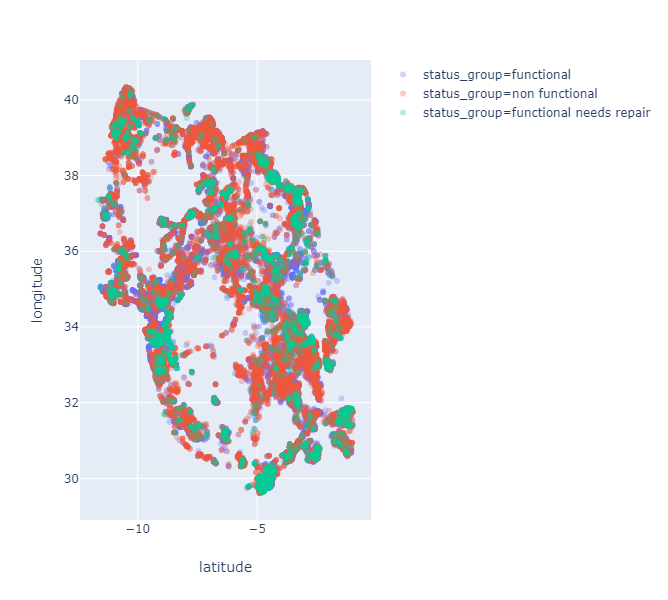

In [36]:
fig = px.scatter(train, x='latitude', y='longitude', color='status_group', 
                 opacity=0.3, width = 800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [81]:
# Defining target and features
target = 'status_group'
train_features = train.drop(columns=[target, 'id'])

# Separate features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
obj_features = train_features.select_dtypes(exclude='number').nunique()

# Split Obj_Features to those <=30 and >30
#   keeping a list of those dropped for potential exploration later
categorical_features = obj_features[obj_features <= 15].index.tolist()
withheld_features = obj_features[obj_features > 15].index.tolist()

In [82]:
features = numeric_features + categorical_features
features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'basin',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [21]:
#  Define subset df's for processing
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [30]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=55)
)

pipeline.fit(X_train, y_train)

print('Baseline Accuracy: \n', '{:20.5f}'.format(baseline))
print('Train Accuracy: \n', '{:20.5f}'.format(pipeline.score(X_train, y_train)))
print('Validation Accuracy: \n', '{:20.5f}'.format(pipeline.score(X_val, y_val)))

y_pred = pipeline.predict(X_test)

Baseline Accuracy: 
              0.54308
Train Accuracy: 
              0.99543
Validation Accuracy: 
              0.75556


In [115]:
len(features)

28

In [117]:
# creating a list of all possible comabinations 
possFeats = []
for i in range(26, len(features)+1):
    for j in combinations(features, i):
        possFeats += j
print(len(possFeats))

10612


In [ ]:
bruteCalcs = pd.DataFrame(
    {'features': [],
     'trainAcc': [],
     'valAcc': []},
    index = []
)


In [ ]:
def bruteForceAnalysis():
    for i in possFeats:
        features = 
        X_train = train[features]
        y_train = train[target]
        X_val = val[features]
        y_val = val[target]

        pipeline.fit(X_train, y_train)

        print('Baseline Accuracy: \n', '{:20.5f}'.format(baseline))
        print('Train Accuracy: \n', '{:20.5f}'.format(pipeline.score(X_train, y_train)))
        print('Validation Accuracy: \n', '{:20.5f}'.format(pipeline.score(X_val, y_val)))

y_pred = pipeline.predict(X_test)

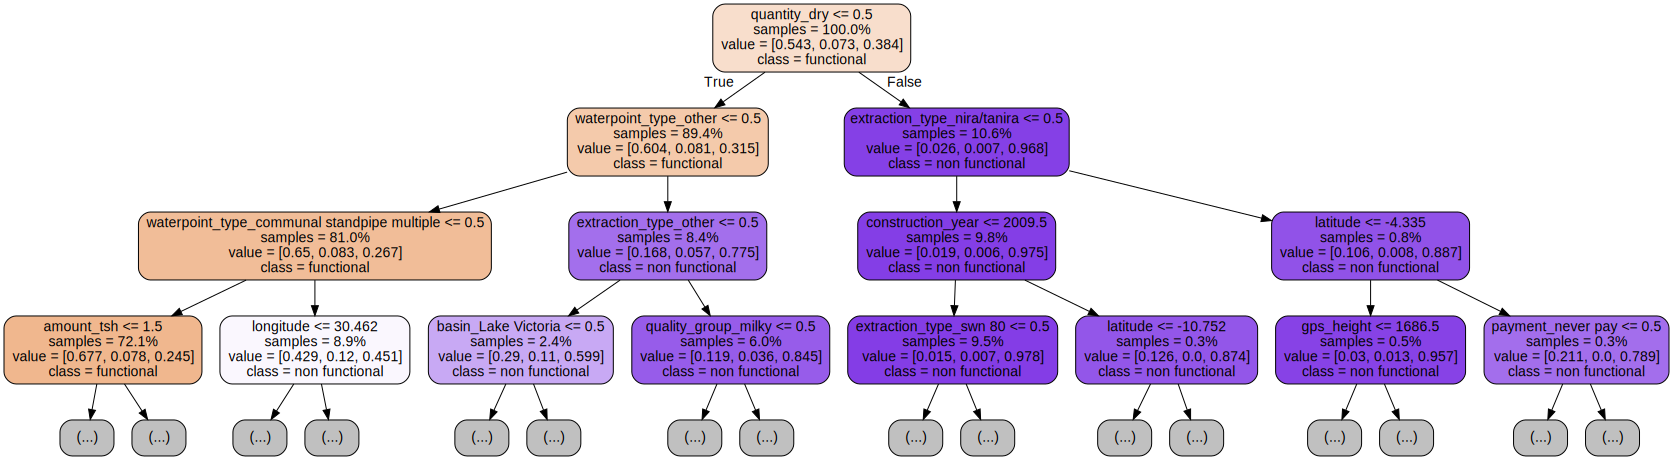

In [32]:
# Plot feature importances

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))